# Exploring the Latent Space of NTv2 500m-Human-Ref (First Layer)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
import pandas as pd
from tqdm import tqdm

from hsg.pipelines.variantmap import DNAVariantProcessor
from hsg.stattools.features import *

from dotenv import load_dotenv
load_dotenv()

True

Here we package the SAE together with its parent model in a single class for convenience. See "hsg.stattools" for details.

In [2]:
layer = 23
extractor = get_latent_model(os.environ["NT_MODEL"], layer_idx=layer, sae_path=f"/home/ek224/Downloads/hidden-state-genomics/sae/layer_{layer}.pt")

In [3]:
# to save time, we'll load the data from the cache
try:
    df = pd.read_csv("./data/clingen_w_seqs.csv")

except:

    # load clingen dataset
    df = pd.read_csv(os.environ["CLIN_GEN_CSV"], header="infer", sep="\t")

    # parse the variants and get some unique refseq sequences
    processor = DNAVariantProcessor()

    refseqs = []
    varseqs = []
    for row in tqdm(df["HGVS Expressions"]):

        # try to pick out expressions listed in genomic coordinates
        exp = row.split(",")
        expression = None

        for i, e in enumerate(exp):
            if ":g." in e:
                expression = e
                break
            if i == len(exp) -1:
                expression = e
            else:
                continue
    
        try:
            # strip gene names & protein mutation tags
            expression = processor.clean_hgvs(expression)
            # parse variant
            var_obj = processor.parse_variant(expression)
            # perform liftover for various assemblies
            var_obj = processor.genomic_sequence_projection(var_obj)
            # get sequences
            refseq = processor.retrieve_refseq(var_obj)
            varseq = processor.retrieve_variantseq(var_obj)
            # append to lists
            refseqs.append(refseq)
            varseqs.append(varseq)
        
        # return nulls if we can't parse the variant
        except:
            refseqs.append(None)
            varseqs.append(None)

    # add the refseqs and varseqs to the dataframe
    df["refseqs"] = refseqs
    df["varseqs"] = varseqs

    # cache this data for later
    df.to_csv("./data/clingen_w_seqs.csv", index=False)



# keep only unique refseqs and remove nulls
df = df.drop_duplicates(subset=["refseqs"])
df = df.dropna(subset=["refseqs"])

# due to resource constraints, we'll take a sample of 200
df = df.sample(100)
print(f"Number of Unique Refseqs: {len(df)}")

Number of Unique Refseqs: 100


Now we can extract the latent features and see how they compare to the original embeddings for interpretability.

To explore the embeddings, we'll pick a couple of the Clin Gen annotation categories to look at:

In [4]:
features = []
original_embeds = []

# get the features and embeddings
errors = []
for entry in tqdm(df["varseqs"]):
    
    with torch.no_grad():
        feats, embeds, reconstructions = extractor.forward(entry, return_hidden_states=True, return_reconstructions=True)
        features.append(feats.cpu())
        original_embeds.append(embeds.cpu())

        error = torch.nn.functional.mse_loss(reconstructions, embeds)
        errors.append(error.item())
        
# print the average error
print(f"Average Reconstruction MSE: {sum(errors)/len(errors)}")

100%|██████████| 100/100 [00:19<00:00,  5.05it/s]

Average Reconstruction MSE: 0.7917408323287964


## Assessing Feature Activation Patterns

At this point, its important to ensure the training did its job and only a handful of active features are present for each embedding. Below, we'll take a look at the activation patterns for some of the feature tensors and see how many are non-zero.

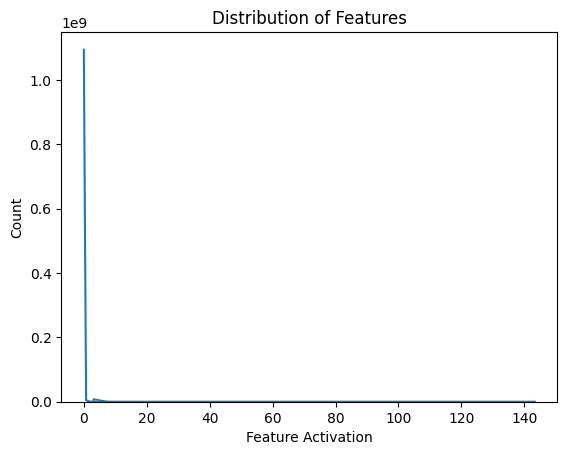

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# just one sample due to RAM constraints
sns.histplot(features[42].flatten().numpy(), kde=True, element="poly")
plt.title("Distribution of Features")
plt.xlabel("Feature Activation")
plt.ylabel("Count")
plt.show()

Due to the skew in the previous figure, let's look at a log scaled version of it below:

*Due to the artifact of normalization, any value less than 10^0 (aka 1) in the plot below is actually zero in the original vector. You can visualize this as any value left of the red line.*

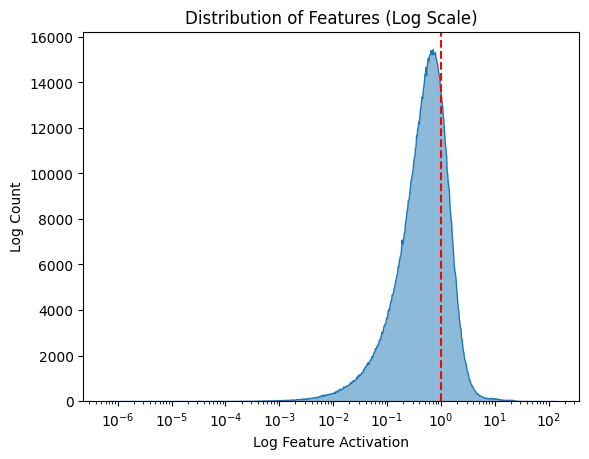

In [6]:
# RAM limits prevent us from running the full dataset
sns.histplot(features[42].flatten().numpy(), kde=True, element="poly", log_scale=True)
plt.axvline(1, color="red", linestyle="--")
plt.title("Distribution of Features (Log Scale)")
plt.xlabel("Log Feature Activation")
plt.ylabel("Log Count")
plt.show()

For an individual feature, that log distribution can look something like this:

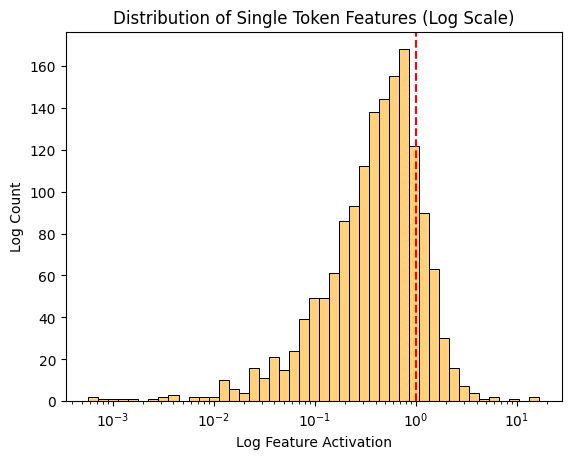

In [7]:
sns.histplot(features[42][500].numpy(), kde=True, element="bars", color="orange", log_scale=True)
plt.axvline(1, color="red", linestyle="--")
plt.title("Distribution of Single Token Features (Log Scale)")
plt.xlabel("Log Feature Activation")
plt.ylabel("Log Count")
plt.show()

### Feature Importance with SAEs

The feature layer weights are an important component of SAEs since they represent the transformation of superimposed features to interpretable features. The weights in this layer therefore correlate with the relative feature importance of a given feature in the principal model's prediction.

Given the structure of the model, it should be unsurprising that the encoder weights follow a gaussian (normal) distribution pattern, suggesting that there is a bit of noise filtering occuring in this single layer encoder.

(10240, 1280)


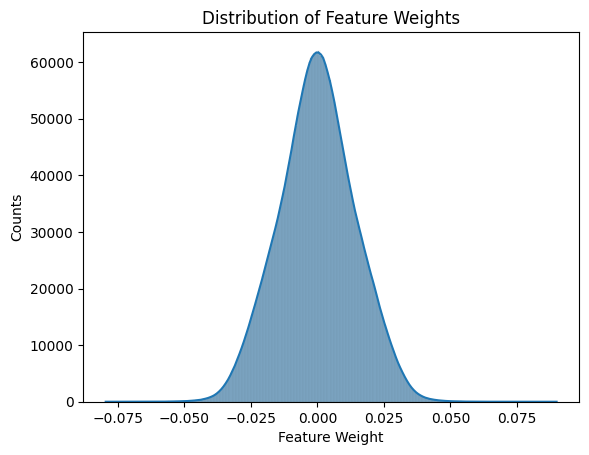

In [8]:
weights = extractor.sae.encoder.weight.cpu().detach().numpy()
print(weights.shape)
sns.histplot(weights.flatten(), kde=True)
plt.title('Distribution of Feature Weights')
plt.xlabel('Feature Weight')
plt.ylabel('Counts')
plt.show()

### Exploring Sequence-level Feature Correlations

To establish the validity of these latent feature vectors that we've trained, we need to evaluate the behavior of these features and draw some correlation between when they activate and conceptual information about the samples they activate on.

Exploring this space is rather complex, especially since our feature activations are distributed across individual tokens rather than sequences as a whole. We tend to annotate DNA sequence regions based on functionality, so we'll have to start by clustering some feature activations and see if we can find some patterns to build off of.


In [9]:
def get_active_features(features: torch.Tensor, threshold: float = 1.0) -> torch.Tensor:
    return torch.where(features > threshold, torch.tensor(1), torch.tensor(0))

active_features = get_active_features(features[42], threshold=1.0)
print(active_features.shape)

torch.Size([1000, 10240])


In [10]:
sequence_feature_activity = active_features.sum(dim=0)
print(sequence_feature_activity.shape)

sequence_feature_attention = active_features.sum(dim=1)
print(sequence_feature_attention.shape)

torch.Size([10240])
torch.Size([1000])


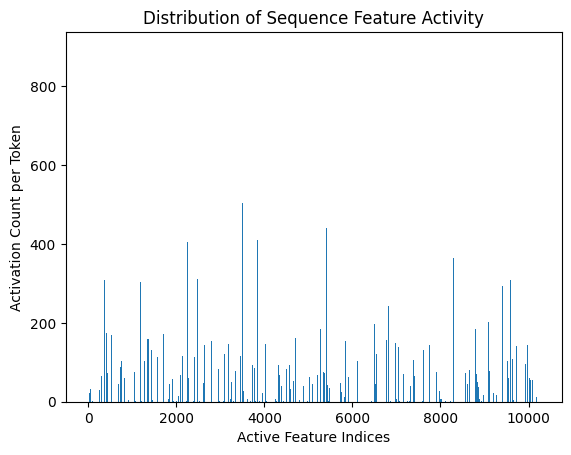

In [11]:
plt.bar(range(len(sequence_feature_activity)), sequence_feature_activity.numpy())
plt.title("Distribution of Sequence Feature Activity")
plt.xlabel("Active Feature Indices")
plt.ylabel("Activation Count per Token")
plt.show()

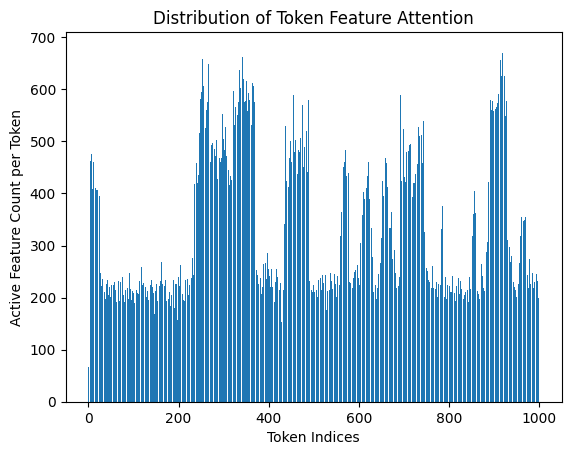

In [12]:
plt.bar(range(len(sequence_feature_attention)), sequence_feature_attention.numpy())
plt.title("Distribution of Token Feature Attention")
plt.xlabel("Token Indices")
plt.ylabel("Active Feature Count per Token")
plt.show()

The Feature activation patterns look promising, but we are also interested in seeing whether features can explain the "interestingness" of variant sequences. So, lets take a look at that:

### Funny Looking Variant Sequences?

Pathogenicity: Pathogenic


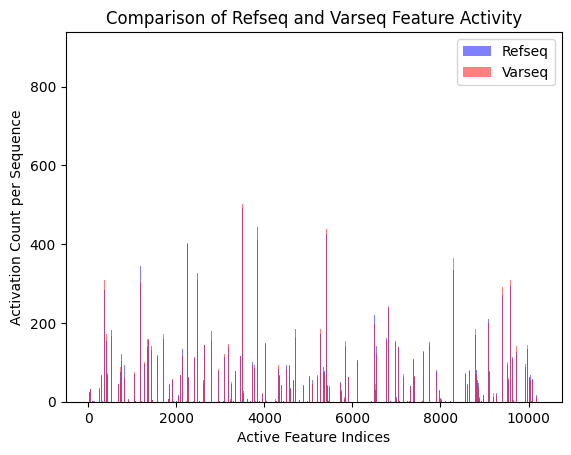

In [13]:
# compare refseq and varseq feature activity
sample = 42
print(f"Pathogenicity: {df["Assertion"].iloc[sample]}")

with torch.no_grad():
    refseq_features, refseq_embeds = extractor.forward(df["refseqs"].iloc[sample], return_hidden_states=True)
    varseq_features, varseq_embeds = extractor.forward(df["varseqs"].iloc[sample], return_hidden_states=True)

refseq_active_features = get_active_features(refseq_features.cpu(), threshold=1.0)
refseq_feature_activity = refseq_active_features.sum(dim=0)
varseq_active_features = get_active_features(varseq_features.cpu(), threshold=1.0)
varseq_feature_activity = varseq_active_features.sum(dim=0)

plt.bar(range(len(refseq_feature_activity)), refseq_feature_activity.numpy(), color="blue", alpha=0.5, label="Refseq")
plt.bar(range(len(varseq_feature_activity)), varseq_feature_activity.numpy(), color="red", alpha=0.5, label="Varseq")
plt.title("Comparison of Refseq and Varseq Feature Activity")
plt.xlabel("Active Feature Indices")
plt.ylabel("Activation Count per Sequence")
plt.legend()
plt.show()

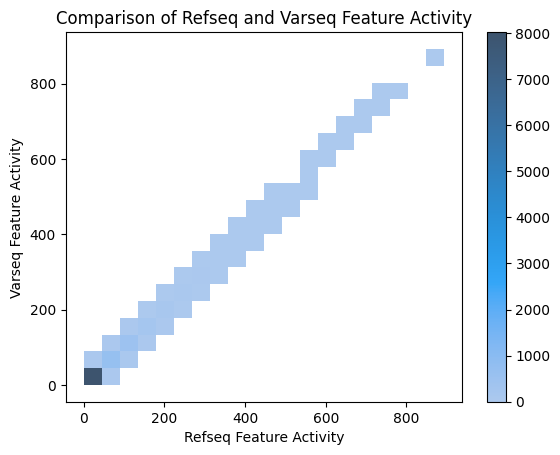

In [14]:
sns.histplot(x=refseq_feature_activity.numpy(), y=varseq_feature_activity.numpy(), bins=20, cbar=True)
plt.title("Comparison of Refseq and Varseq Feature Activity")
plt.xlabel("Refseq Feature Activity")
plt.ylabel("Varseq Feature Activity")
plt.show()

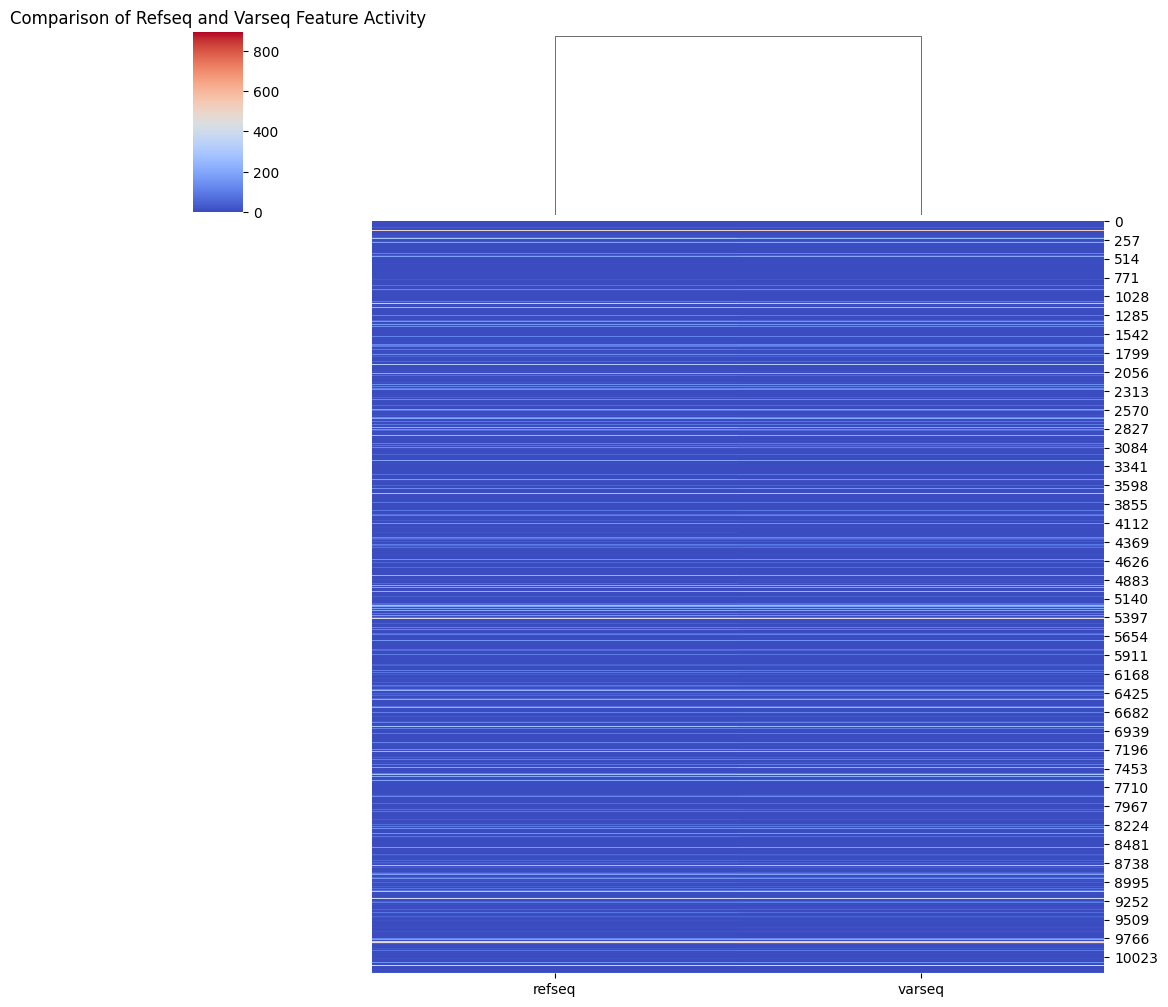

In [16]:
sns.clustermap({"refseq":refseq_feature_activity.numpy(), "varseq":varseq_feature_activity.numpy()}, cmap="coolwarm", row_cluster=False)
plt.title("Comparison of Refseq and Varseq Feature Activity")
plt.show()

### Comparing Raw Attention Maps to Feature Maps

So, the feature patterns themselves don't seem terribly promising, much like the UMAPs previously looked - however, I wanted to see how raw attention mapping compares to feature activity for identifying what DNA Language models pick up on:

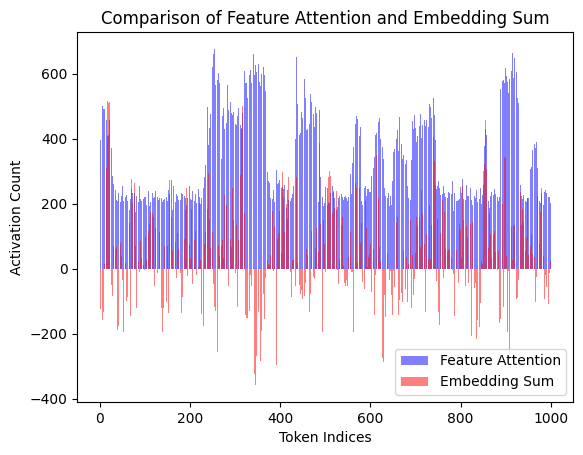

In [17]:
varseq_feat_attn = varseq_active_features.sum(dim=1)
varseq_attn = varseq_embeds.sum(dim=1).cpu()

plt.bar(range(len(varseq_feat_attn)), varseq_feat_attn.numpy(), color="blue", alpha=0.5, label="Feature Attention")
plt.bar(range(len(varseq_attn)), varseq_attn.numpy(), color="red", alpha=0.5, label="Embedding Sum")
plt.title("Comparison of Feature Attention and Embedding Sum")
plt.xlabel("Token Indices")
plt.ylabel("Activation Count")
plt.legend()
plt.show()

Just in case there was a difference in the feature activity map between the variant and reference sequences:

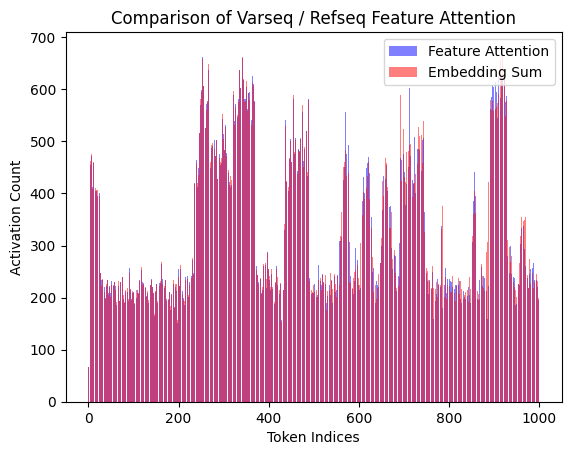

In [18]:
refseq_feat_attn = refseq_active_features.sum(dim=1)
refseq_attn = refseq_embeds.sum(dim=1).cpu()

plt.bar(range(len(refseq_feat_attn)), refseq_feat_attn.numpy(), color="blue", alpha=0.5, label="Feature Attention")
plt.bar(range(len(varseq_feat_attn)), varseq_feat_attn.numpy(), color="red", alpha=0.5, label="Embedding Sum")
plt.title("Comparison of Varseq / Refseq Feature Attention")
plt.xlabel("Token Indices")
plt.ylabel("Activation Count")
plt.legend()
plt.show()

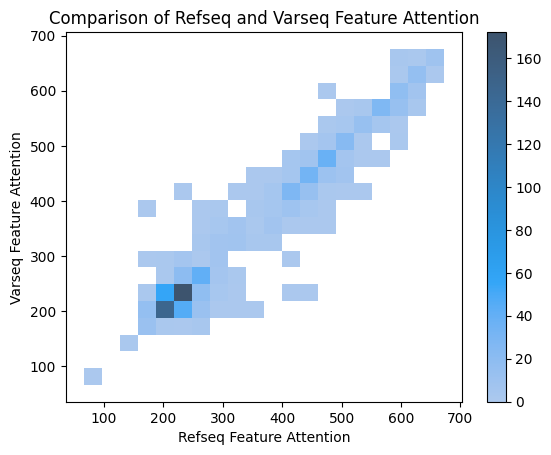

In [19]:
sns.histplot(x=refseq_feat_attn.numpy(), y=varseq_feat_attn.numpy(), bins=20, cbar=True)
plt.title("Comparison of Refseq and Varseq Feature Attention")
plt.xlabel("Refseq Feature Attention")
plt.ylabel("Varseq Feature Attention")
plt.show()

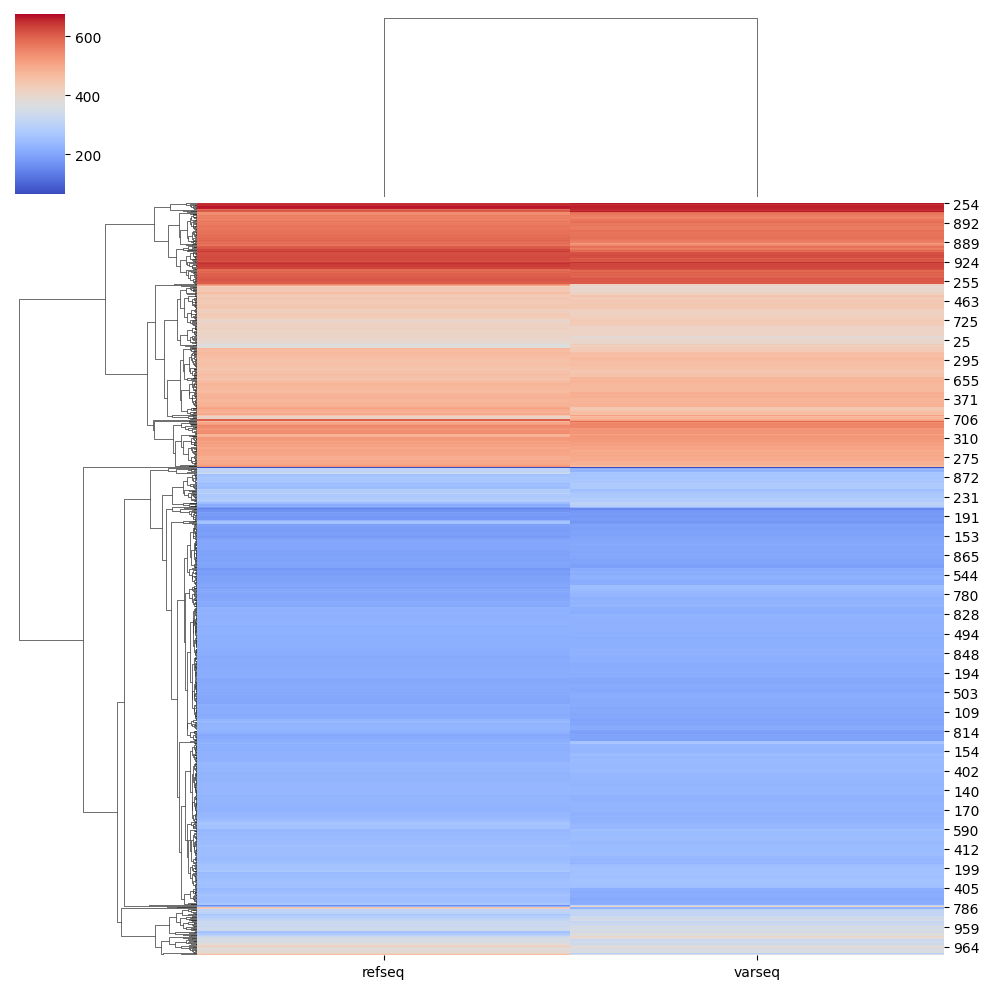

In [20]:
sns.clustermap({"refseq":refseq_feat_attn.numpy(), "varseq":varseq_feat_attn.numpy()}, cmap="coolwarm")